- generate  64×64 animal images by training a DDPM using the AFHQ dataset
- training
    - -> python train.py
- Sampling
    - python sampling.py --ckpt_path ${CKPT_PATH} --save_dir ${SAVE_DIR_PATH}
    - sample images and save a checkpoint every args.log_interval
- FID
    - python dataset.py # to constuct eval directory.
    - python fid/measure_fid.py @GT_IMG_DIR @ GEN_IMG_DIR

# CFG Classifier-Free Guidance

# CFG Training

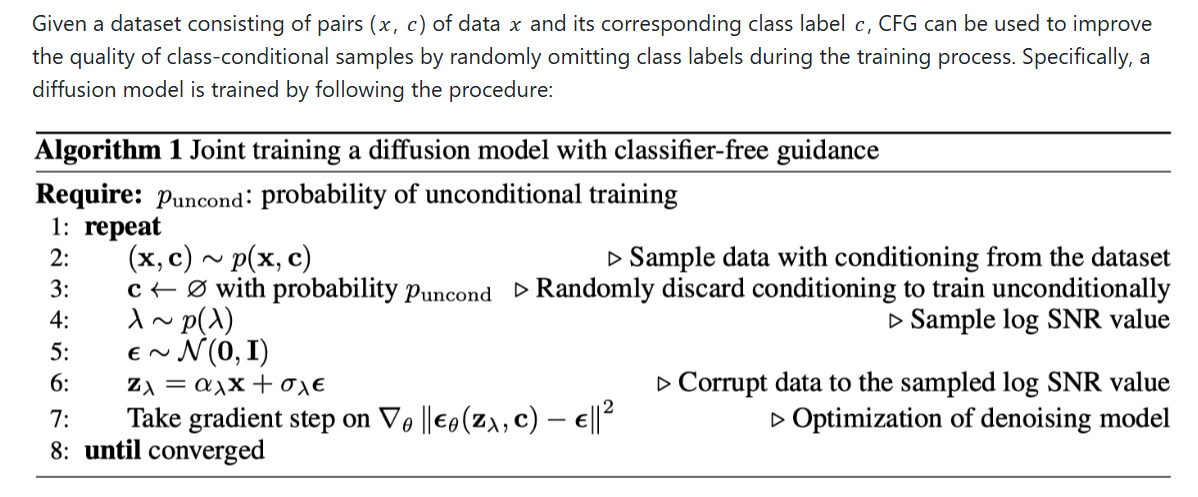

# CFG Sampling

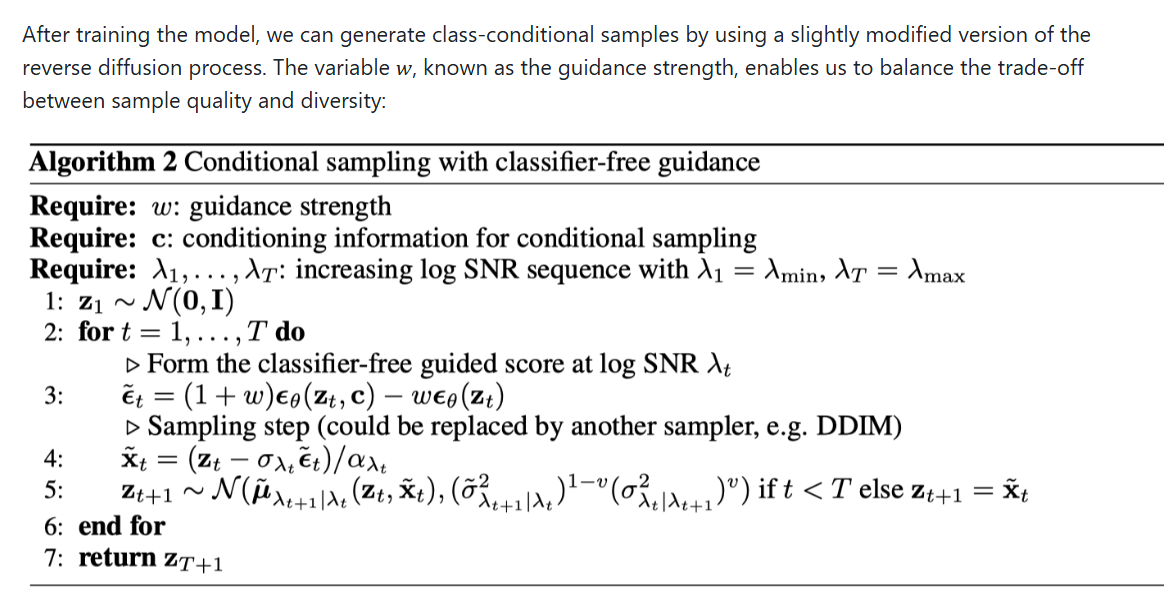

# Libraries

In [ ]:
import os
import sys

from itertools import chain
from multiprocessing.pool import Pool
from pathlib import Path
import argparse
import json
from datetime import datetime
from PIL import Image

from typing import Optional, Union

import numpy as np
import math
from scipy import linalg

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init

from torchvision import transforms
from torchvision import models
from torchvision.transforms.functional import to_pil_image
import torchvision.transforms as transforms

from tqdm import tqdm
from dotmap import DotMap
from pytorch_lightning import seed_everything

import matplotlib
import matplotlib.pyplot as plt
matplotlib.use("Agg")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from torch.nn import DataParallel


In [13]:
device

device(type='cuda', index=3)

# Swish

In [14]:
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

# Down Sample

In [15]:
class DownSample(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        self.main = nn.Conv2d(in_ch, in_ch, 3, stride=2, padding=1)
        self.initialize()

    def initialize(self):
        init.xavier_uniform_(self.main.weight)
        init.zeros_(self.main.bias)

    def forward(self, x, temb):
        x = self.main(x)
        return x

# Up Sample

In [8]:
class UpSample(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        self.main = nn.Conv2d(in_ch, in_ch, 3, stride=1, padding=1)
        self.initialize()

    def initialize(self):
        init.xavier_uniform_(self.main.weight)
        init.zeros_(self.main.bias)

    def forward(self, x, temb):
        _, _, H, W = x.shape
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        x = self.main(x)
        return x

# Attention Block

In [9]:
class AttnBlock(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        self.group_norm = nn.GroupNorm(32, in_ch)
        self.proj_q = nn.Conv2d(in_ch, in_ch, 1, stride=1, padding=0)
        self.proj_k = nn.Conv2d(in_ch, in_ch, 1, stride=1, padding=0)
        self.proj_v = nn.Conv2d(in_ch, in_ch, 1, stride=1, padding=0)
        self.proj = nn.Conv2d(in_ch, in_ch, 1, stride=1, padding=0)
        self.initialize()

    def initialize(self):
        for module in [self.proj_q, self.proj_k, self.proj_v, self.proj]:
            init.xavier_uniform_(module.weight)
            init.zeros_(module.bias)
        init.xavier_uniform_(self.proj.weight, gain=1e-5)

    def forward(self, x):
        B, C, H, W = x.shape
        h = self.group_norm(x)
        q = self.proj_q(h)
        k = self.proj_k(h)
        v = self.proj_v(h)

        q = q.permute(0, 2, 3, 1).view(B, H * W, C)
        k = k.view(B, C, H * W)
        w = torch.bmm(q, k) * (int(C) ** (-0.5))
        assert list(w.shape) == [B, H * W, H * W]
        w = F.softmax(w, dim=-1)

        v = v.permute(0, 2, 3, 1).view(B, H * W, C)
        h = torch.bmm(w, v)
        assert list(h.shape) == [B, H * W, C]
        h = h.view(B, H, W, C).permute(0, 3, 1, 2)
        h = self.proj(h)

        return x + h

# Residual Block

In [10]:
class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, tdim, dropout, attn=False):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.GroupNorm(32, in_ch),
            Swish(),
            nn.Conv2d(in_ch, out_ch, 3, stride=1, padding=1),
        )
        self.temb_proj = nn.Sequential(
            Swish(),
            nn.Linear(tdim, out_ch),
        )
        self.block2 = nn.Sequential(
            nn.GroupNorm(32, out_ch),
            Swish(),
            nn.Dropout(dropout),
            nn.Conv2d(out_ch, out_ch, 3, stride=1, padding=1),
        )
        if in_ch != out_ch:
            self.shortcut = nn.Conv2d(in_ch, out_ch, 1, stride=1, padding=0)
        else:
            self.shortcut = nn.Identity()
        if attn:
            self.attn = AttnBlock(out_ch)
        else:
            self.attn = nn.Identity()
        self.initialize()

    def initialize(self):
        for module in self.modules():
            if isinstance(module, (nn.Conv2d, nn.Linear)):
                init.xavier_uniform_(module.weight)
                init.zeros_(module.bias)
        init.xavier_uniform_(self.block2[-1].weight, gain=1e-5)

    def forward(self, x, temb):
        h = self.block1(x)
        h += self.temb_proj(temb)[:, :, None, None]
        h = self.block2(h)

        h = h + self.shortcut(x)
        h = self.attn(h)
        return h


# Time Embedding

In [11]:
class TimeEmbedding(nn.Module):
    def __init__(self, hidden_size, frequency_embedding_size=256):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(frequency_embedding_size, hidden_size, bias=True),
            nn.SiLU(),
            nn.Linear(hidden_size, hidden_size, bias=True),
        )
        self.frequency_embedding_size = frequency_embedding_size

    @staticmethod
    def timestep_embedding(t, dim, max_period=10000):
        """
        Create sinusoidal timestep embeddings.
        :param t: a 1-D Tensor of N indices, one per batch element.
                          These may be fractional.
        :param dim: the dimension of the output.
        :param max_period: controls the minimum frequency of the embeddings.
        :return: an (N, D) Tensor of positional embeddings.
        """
        # https://github.com/openai/glide-text2im/blob/main/glide_text2im/nn.py
        half = dim // 2
        freqs = torch.exp(
            -math.log(max_period)
            * torch.arange(start=0, end=half, dtype=torch.float32)
            / half
        ).to(device=t.device)
        args = t[:, None].float() * freqs[None]
        embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
        if dim % 2:
            embedding = torch.cat(
                [embedding, torch.zeros_like(embedding[:, :1])], dim=-1
            )
        return embedding

    def forward(self, t):
        if t.ndim == 0:
            t = t.unsqueeze(-1)
        t_freq = self.timestep_embedding(t, self.frequency_embedding_size)
        t_emb = self.mlp(t_freq)
        return t_emb

# U-Net

In [11]:
class UNet(nn.Module):
    def __init__(self, T=1000, image_resolution=64, ch=128, ch_mult=[1,2,2,2], attn=[1], num_res_blocks=4, dropout=0.1, use_cfg=False, cfg_dropout=0.1, num_classes=None):
        super().__init__()
        self.image_resolution = image_resolution
        assert all([i < len(ch_mult) for i in attn]), 'attn index out of bound'
        tdim = ch * 4
        # self.time_embedding = TimeEmbedding(T, ch, tdim)
        self.time_embedding = TimeEmbedding(tdim)

        # classifier-free guidance
        self.use_cfg = use_cfg
        self.cfg_dropout = cfg_dropout
        if use_cfg:
            assert num_classes is not None
            cdim = tdim
            self.class_embedding = nn.Embedding(num_classes+1, cdim)

        self.head = nn.Conv2d(3, ch, kernel_size=3, stride=1, padding=1)
        self.downblocks = nn.ModuleList()
        chs = [ch]  # record output channel when dowmsample for upsample
        now_ch = ch
        for i, mult in enumerate(ch_mult):
            out_ch = ch * mult
            for _ in range(num_res_blocks):
                self.downblocks.append(ResBlock(
                    in_ch=now_ch, out_ch=out_ch, tdim=tdim,
                    dropout=dropout, attn=(i in attn)))
                now_ch = out_ch
                chs.append(now_ch)
            if i != len(ch_mult) - 1:
                self.downblocks.append(DownSample(now_ch))
                chs.append(now_ch)

        self.middleblocks = nn.ModuleList([
            ResBlock(now_ch, now_ch, tdim, dropout, attn=True),
            ResBlock(now_ch, now_ch, tdim, dropout, attn=False),
        ])

        self.upblocks = nn.ModuleList()
        for i, mult in reversed(list(enumerate(ch_mult))):
            out_ch = ch * mult
            for _ in range(num_res_blocks + 1):
                self.upblocks.append(ResBlock(
                    in_ch=chs.pop() + now_ch, out_ch=out_ch, tdim=tdim,
                    dropout=dropout, attn=(i in attn)))
                now_ch = out_ch
            if i != 0:
                self.upblocks.append(UpSample(now_ch))
        assert len(chs) == 0

        self.tail = nn.Sequential(
            nn.GroupNorm(32, now_ch),
            Swish(),
            nn.Conv2d(now_ch, 3, 3, stride=1, padding=1)
        )
        self.initialize()

    def initialize(self):
        init.xavier_uniform_(self.head.weight)
        init.zeros_(self.head.bias)
        init.xavier_uniform_(self.tail[-1].weight, gain=1e-5)
        init.zeros_(self.tail[-1].bias)

    def forward(self, x, timestep, class_label=None):
        # Timestep embedding
        temb = self.time_embedding(timestep)

        if self.use_cfg and class_label is not None:
            if self.training:
                assert not torch.any(class_label == 0) # 0 for null.
                
                ######## TODO ########
                # DO NOT change the code outside this part.
                # Assignment 2. Implement random null conditioning in CFG training.
                if torch.randn() < self.cfg_dropout:
                    class_label = torch.zeros_like(class_label)
                else:
                    class_label = class_label
                #######################
            
            ######## TODO ########
            # DO NOT change the code outside this part.
            # Assignment 2. Implement class conditioning
            cemb = self.class_embedding(class_label)

            temb = temb + cemb
            #######################

        # Downsampling
        h = self.head(x)
        hs = [h]
        for layer in self.downblocks:
            h = layer(h, temb)
            hs.append(h)
        # Middle
        for layer in self.middleblocks:
            h = layer(h, temb)
        # Upsampling
        for layer in self.upblocks:
            if isinstance(layer, ResBlock):
                h = torch.cat([h, hs.pop()], dim=1)
            h = layer(h, temb)
        h = self.tail(h)

        assert len(hs) == 0
        return h

# Base Scheduler

In [12]:
class BaseScheduler(nn.Module):
    def __init__(
        self, num_train_timesteps: int, beta_1: float, beta_T: float, mode="linear"
    ):
        super().__init__()
        self.num_train_timesteps = num_train_timesteps
        self.num_inference_timesteps = num_train_timesteps
        self.timesteps = torch.from_numpy(
            np.arange(0, self.num_train_timesteps)[::-1].copy().astype(np.int64)
        )

        if mode == "linear":
            betas = torch.linspace(beta_1, beta_T, steps=num_train_timesteps)
        elif mode == "quad":
            betas = (
                torch.linspace(beta_1**0.5, beta_T**0.5, num_train_timesteps) ** 2
            )
        else:
            raise NotImplementedError(f"{mode} is not implemented.")

        alphas = 1 - betas
        alphas_cumprod = torch.cumprod(alphas, dim=0)

        self.register_buffer("betas", betas)
        self.register_buffer("alphas", alphas)
        self.register_buffer("alphas_cumprod", alphas_cumprod)

    def uniform_sample_t(
        self, batch_size, device: Optional[torch.device] = None
    ) -> torch.IntTensor:
        """
        Uniformly sample timesteps.
        """
        ts = np.random.choice(np.arange(self.num_train_timesteps), batch_size)
        ts = torch.from_numpy(ts)
        if device is not None:
            ts = ts.to(device)
        return ts

# DDPM Scheduler

- implement the methods add_noise and step of the class DDPMScheduler
- Refer to your implementation of the methods 
    - q_sample -> add_noise
    - p_sample -> step  
    - compute_loss -> get_loss

In [13]:
class DDPMScheduler(BaseScheduler):
    def __init__(
        self,
        num_train_timesteps: int,
        beta_1: float,
        beta_T: float,
        mode="linear",
        sigma_type="small",
    ):
        super().__init__(num_train_timesteps, beta_1, beta_T, mode)
    
        # sigmas correspond to $\sigma_t$ in the DDPM paper.
        self.sigma_type = sigma_type
        if sigma_type == "small":
            # when $\sigma_t^2 = \tilde{\beta}_t$.
            alphas_cumprod_t_prev = torch.cat(
                [torch.tensor([1.0]), self.alphas_cumprod[:-1]]
            )
            sigmas = (
                (1 - alphas_cumprod_t_prev) / (1 - self.alphas_cumprod) * self.betas
            ) ** 0.5
        elif sigma_type == "large":
            # when $\sigma_t^2 = \beta_t$.
            sigmas = self.betas ** 0.5

        self.register_buffer("sigmas", sigmas)

    def step(self, x_t: torch.Tensor, t: int, eps_theta: torch.Tensor):
        """
        One step denoising function of DDPM: x_t -> x_{t-1}.

        Input:
            x_t (`torch.Tensor [B,C,H,W]`): samples at arbitrary timestep t.
            t (`int`): current timestep in a reverse process.
            eps_theta (`torch.Tensor [B,C,H,W]`): predicted noise from a learned model.
        Ouptut:
            sample_prev (`torch.Tensor [B,C,H,W]`): one step denoised sample. (= x_{t-1})
        """

        ######## TODO ########
        # DO NOT change the code outside this part.
        # Assignment 1. Implement the DDPM reverse step.        
        
        if isinstance(t, int):
            t = torch.tensor([t]).to(self.device)

        alpha_t = self._get_teeth(self.alphas.to(device), t)
        alpha_cumprod_t = self._get_teeth(self.alphas_cumprod.to(device), t)
        beta_t = self._get_teeth(self.betas.to(device), t).to(device)

        eps_factor = (1 - alpha_t) / (1 - alpha_cumprod_t).sqrt()
        mean = (x_t - eps_factor*eps_theta) / (alpha_t.sqrt())
        
        sigma = self._get_teeth(self.sigmas.to(device), t)
        noise = torch.randn_like(x_t).to(device)
        
        sample_prev = mean + sigma * noise

        #######################
        
        return sample_prev
    
    # https://nn.labml.ai/diffusion/ddpm/utils.html
    def _get_teeth(self, consts: torch.Tensor, t: torch.Tensor): # get t th const
        t = t.to(consts.device) 
        const = consts.gather(-1, t)
        return const.reshape(-1, 1, 1, 1)
    
    def add_noise(
        self,
        x_0: torch.Tensor,
        t: torch.IntTensor,
        eps: Optional[torch.Tensor] = None,
    ):
        """
        A forward pass of a Markov chain, i.e., q(x_t | x_0).

        Input:
            x_0 (`torch.Tensor [B,C,H,W]`): samples from a real data distribution q(x_0).
            t: (`torch.IntTensor [B]`)
            eps: (`torch.Tensor [B,C,H,W]`, optional): if None, randomly sample Gaussian noise in the function.
        Output:
            x_t: (`torch.Tensor [B,C,H,W]`): noisy samples at timestep t.
            eps: (`torch.Tensor [B,C,H,W]`): injected noise.
        """
        
        if eps is None:
            eps       = torch.randn(x_0.shape, device='cuda')

        ######## TODO ########
        # DO NOT change the code outside this part.
        # Assignment 1. Implement the DDPM forward step.

        alphas_prod_t = self._get_teeth(self.alphas_cumprod, t).to(device)
        x_t = alphas_prod_t.sqrt()*x_0 + (1-alphas_prod_t).sqrt()*eps
        
        #######################

        return x_t, eps

# Diffusion Model

- implement the method get_loss of the class DiffusionModule


In [14]:
class DiffusionModule(nn.Module):
    def __init__(self, network, var_scheduler, **kwargs):
        super().__init__()
        self.network = network
        self.var_scheduler = var_scheduler

    def get_loss(self, x0, class_label=None, noise=None):
        ######## TODO ########
        # DO NOT change the code outside this part.
        # compute noise matching loss.
        B = x0.shape[0]
        timestep = self.var_scheduler.uniform_sample_t(B, self.device)
                
        xt_pred, injected_noise = self.var_scheduler.add_noise(x0, timestep, noise)
        
        pred_noise = self.network(xt_pred, timestep)
        
        loss = F.mse_loss(pred_noise, injected_noise)
        ######################
        return loss
    
    @property
    def device(self):
        return next(self.network.parameters()).device

    @property
    def image_resolution(self):
        return self.network.image_resolution

    @torch.no_grad()
    def sample(
        self,
        batch_size,
        return_traj=False,
        class_label: Optional[torch.Tensor] = None,
        guidance_scale: Optional[float] = 0.0,
    ):
        x_T = torch.randn([batch_size, 3, self.image_resolution, self.image_resolution]).to(self.device)

        do_classifier_free_guidance = guidance_scale > 0.0

        if do_classifier_free_guidance:

            ######## TODO ########
            # Assignment 2. Implement the classifier-free guidance.
            # Specifically, given a tensor of shape (batch_size,) containing class labels,
            # create a tensor of shape (2*batch_size,) where the first half is filled with zeros (i.e., null condition).
            assert class_label is not None
            assert len(class_label) == batch_size, f"len(class_label) != batch_size. {len(class_label)} != {batch_size}"
            null_class_label  =   torch.zeros_like(class_label)
            #######################

        traj = [x_T]
        for t in tqdm(self.var_scheduler.timesteps):
            x_t = traj[-1]
            if do_classifier_free_guidance:
                ######## TODO ########
                # Assignment 2. Implement the classifier-free guidance.
                noise_pred = (1+guidance_scale) * self.network(x_t, timestep=t.to(self.device), class_label=class_label) - guidance_scale * self.network(x_t, timestep=t.to(self.device), class_label=null_class_label)
                #######################
            else:
                noise_pred = self.network(x_t, timestep=t.to(self.device))

            x_t_prev = self.var_scheduler.step(x_t, t, noise_pred)

            traj[-1] = traj[-1].cpu()
            traj.append(x_t_prev.detach())

        if return_traj:
            return traj
        else:
            return traj[-1]

    def save(self, file_path):
        hparams = {
            "network": self.network,
            "var_scheduler": self.var_scheduler,
            } 
        state_dict = self.state_dict()

        dic = {"hparams": hparams, "state_dict": state_dict}
        torch.save(dic, file_path)

    def load(self, file_path):
        dic = torch.load(file_path, map_location="cpu")
        hparams = dic["hparams"]
        state_dict = dic["state_dict"]

        self.network = hparams["network"]
        self.var_scheduler = hparams["var_scheduler"]

        self.load_state_dict(state_dict)

# Datasets

In [ ]:
def listdir(dname):
    fnames = list(
        chain(
            *[
                list(Path(dname).rglob("*." + ext))
                for ext in ["png", "jpg", "jpeg", "JPG"]
            ]
        )
    )
    return fnames

def tensor_to_pil_image(x: torch.Tensor, single_image=False):
    """
    x: [B,C,H,W]
    """
    if x.ndim == 3:
        x = x.unsqueeze(0)
        single_image = True

    x = (x * 0.5 + 0.5).clamp(0, 1).detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (x * 255).round().astype("uint8")
    images = [Image.fromarray(image) for image in images]
    if single_image:
        return images[0]
    return images

def get_data_iterator(iterable):
    """Allows training with DataLoaders in a single infinite loop:
    for i, data in enumerate(inf_generator(train_loader)):
    """
    iterator = iterable.__iter__()
    while True:
        try:
            yield iterator.__next__()
        except StopIteration:
            iterator = iterable.__iter__()




In [ ]:
class AFHQDataset(torch.utils.data.Dataset):
    def __init__(
        self, root: str, split: str, transform=None, max_num_images_per_cat=-1, label_offset=1
    ):
        super().__init__()
        self.root = root
        self.split = split
        self.transform = transform
        self.max_num_images_per_cat = max_num_images_per_cat
        self.label_offset = label_offset

        categories = os.listdir(os.path.join(root, split))
        self.num_classes = len(categories)

        fnames, labels = [], []
        for idx, cat in enumerate(sorted(categories)):
            category_dir = os.path.join(root, split, cat)
            cat_fnames = listdir(category_dir)
            cat_fnames = sorted(cat_fnames)
            if self.max_num_images_per_cat > 0:
                cat_fnames = cat_fnames[: self.max_num_images_per_cat]
            fnames += cat_fnames
            labels += [idx + label_offset] * len(cat_fnames)  # label 0 is for null class.

        self.fnames = fnames
        self.labels = labels

    def __getitem__(self, idx):
        img = Image.open(self.fnames[idx]).convert("RGB")
        label = self.labels[idx]
        assert label >= self.label_offset
        if self.transform is not None:
            img = self.transform(img)

        return img, label

    def __len__(self):
        return len(self.labels)


In [ ]:
class AFHQDataModule(object):
    def __init__(
        self,
        root: str = "data",
        batch_size: int = 32,
        num_workers: int = 4,
        max_num_images_per_cat: int = 1000,
        image_resolution: int = 64,
        label_offset=1,
        transform=None
    ):
        self.root = root
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.afhq_root = os.path.join(root, "afhq")
        self.max_num_images_per_cat = max_num_images_per_cat
        self.image_resolution = image_resolution
        self.label_offset = label_offset
        self.transform = transform

        if not os.path.exists(self.afhq_root):
            print(f"{self.afhq_root} is empty. Downloading AFHQ dataset...")
            self._download_dataset()

        self._set_dataset()

    def _set_dataset(self):
        if self.transform is None:
            self.transform = transforms.Compose(
                [
                    transforms.Resize((self.image_resolution, self.image_resolution)),
                    transforms.ToTensor(),
                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                ]
            )
        self.train_ds = AFHQDataset(
            self.afhq_root,
            "train",
            self.transform,
            max_num_images_per_cat=self.max_num_images_per_cat,
            label_offset=self.label_offset
        )
        self.val_ds = AFHQDataset(
            self.afhq_root,
            "val",
            self.transform,
            max_num_images_per_cat=self.max_num_images_per_cat,
            label_offset=self.label_offset,
        )

        self.num_classes = self.train_ds.num_classes

    def _download_dataset(self):
        URL = "https://www.dropbox.com/s/t9l9o3vsx2jai3z/afhq.zip?dl=0"
        ZIP_FILE = f"./{self.root}/afhq.zip"
        os.system(f"mkdir -p {self.root}")
        os.system(f"wget -N {URL} -O {ZIP_FILE}")
        os.system(f"unzip {ZIP_FILE} -d {self.root}")
        os.system(f"rm {ZIP_FILE}")

    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            self.train_ds,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True,
            drop_last=True,
        )

    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            self.val_ds,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            drop_last=False,
        )
    

if __name__ == "__main__":
    data_module = AFHQDataModule("data", 32, 4, -1, 64, 1)

    eval_dir = Path(data_module.afhq_root) / "eval"
    eval_dir.mkdir(exist_ok=True)
    def func(path):
        fn = path.name
        cmd = f"cp {path} {eval_dir / fn}"
        os.system(cmd)
        img = Image.open(str(eval_dir / fn))
        img = img.resize((64,64))
        img.save(str(eval_dir / fn))
        print(fn)

    with Pool(8) as pool:
        pool.map(func, data_module.val_ds.fnames)

    print(f"Constructed eval dir at {eval_dir}")

data/afhq is empty. Downloading AFHQ dataset...


for details.

--2025-01-14 20:49:58--  https://www.dropbox.com/s/t9l9o3vsx2jai3z/afhq.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.66.18, 2620:100:6025:18::a27d:4512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.66.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/kpxh6hu04eu28yb8l30wy/afhq.zip?rlkey=usjnva71u164xd4rq6ghlab1u&dl=0 [following]
--2025-01-14 20:49:59--  https://www.dropbox.com/scl/fi/kpxh6hu04eu28yb8l30wy/afhq.zip?rlkey=usjnva71u164xd4rq6ghlab1u&dl=0
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc736b7a4b6a5ef3920b2a09529e.dl.dropboxusercontent.com/cd/0/inline/CiPk6p5xBH0GuH4n_Nbrg8HxSu3n3CUzLAOoHZuSXa0efMtoE56aMPm9yZnOgWK9ZBHlZjeKAER_2-eaESVS86SewBTOpiJivLbjtkkN6heJduAe8noLU6jNULNgzGVFma9R64guPs7pKwYahr9heDEX/file# [following]
--2025-01-14 20:49:59--  https://uc736b7a4b6a5ef3920b2a09529e.dl.dropboxuserconte

Archive:  ./data/afhq.zip
   creating: data/afhq/
   creating: data/afhq/train/
   creating: data/afhq/train/cat/
  inflating: data/afhq/train/cat/flickr_cat_000002.jpg  
  inflating: data/afhq/train/cat/flickr_cat_000003.jpg  
  inflating: data/afhq/train/cat/flickr_cat_000004.jpg  
  inflating: data/afhq/train/cat/flickr_cat_000005.jpg  
  inflating: data/afhq/train/cat/flickr_cat_000006.jpg  
  inflating: data/afhq/train/cat/flickr_cat_000007.jpg  
  inflating: data/afhq/train/cat/flickr_cat_000009.jpg  
  inflating: data/afhq/train/cat/flickr_cat_000010.jpg  
  inflating: data/afhq/train/cat/flickr_cat_000012.jpg  
  inflating: data/afhq/train/cat/flickr_cat_000013.jpg  
  inflating: data/afhq/train/cat/flickr_cat_000014.jpg  
  inflating: data/afhq/train/cat/flickr_cat_000015.jpg  
  inflating: data/afhq/train/cat/flickr_cat_000017.jpg  
  inflating: data/afhq/train/cat/flickr_cat_000018.jpg  
  inflating: data/afhq/train/cat/flickr_cat_000019.jpg  
  inflating: data/afhq/train/ca

# Training

In [15]:
def get_current_time():
    now = datetime.now().strftime("%m-%d-%H%M%S")
    return now

args = {
    "gpu": 0,
    "batch_size": 16,
    "train_num_steps": 100000,
    "warmup_steps": 200,
    "log_interval": 200,
    "max_num_images_per_cat": 3000,
    "num_diffusion_train_timesteps": 1000,
    "beta_1": 1e-4,
    "beta_T": 0.02,
    "seed": 63,
    "image_resolution": 64,
    "sample_method": "ddpm",
    "use_cfg": False,  # Change to True if conditional training is required
    "cfg_dropout": 0.1,
}

args = DotMap(args)

def main(args):
    """config"""
    config = DotMap(args)
    config.update(vars(args))
    config.device = f"cuda:{args.gpu}"

    now = get_current_time()
    if args.use_cfg:
        save_dir = Path(f"results/cfg_diffusion-{args.sample_method}-{now}")
    else:
        save_dir = Path(f"results/diffusion-{args.sample_method}-{now}")
    save_dir.mkdir(exist_ok=True, parents=True)
    print(f"save_dir: {save_dir}")
    
    seed_everything(int(config.seed))
    # seed_everything(config.seed)

    with open(save_dir / "config.json", "w") as f:
        json.dump(config, f, indent=2)
    """######"""

    image_resolution = 64
    ds_module = AFHQDataModule(
        "./data",
        batch_size=config.batch_size,
        num_workers=4,
        max_num_images_per_cat=config.max_num_images_per_cat,
        image_resolution=image_resolution
    )

    train_dl = ds_module.train_dataloader()
    train_it = get_data_iterator(train_dl)

    # Set up the scheduler
    var_scheduler = DDPMScheduler(
        config.num_diffusion_train_timesteps,
        beta_1=config.beta_1,
        beta_T=config.beta_T,
        mode="linear",
    )

    network = UNet(
        T=config.num_diffusion_train_timesteps,
        image_resolution=image_resolution,
        ch=128,
        ch_mult=[1, 2, 2, 2],
        attn=[1],
        num_res_blocks=4,
        dropout=0.1,
        use_cfg=args.use_cfg,
        cfg_dropout=args.cfg_dropout,
        num_classes=getattr(ds_module, "num_classes", None),
    )

    ddpm = DiffusionModule(network, var_scheduler)
    #################################
    ## Parallel Compute
    ddpm = DataParallel(ddpm)
    #################################
    ddpm = ddpm.to(config.device)

    # optimizer = torch.optim.Adam(ddpm.network.parameters(), lr=2e-4)
    optimizer = torch.optim.Adam(ddpm.module.network.parameters(), lr=2e-4)
    scheduler = torch.optim.lr_scheduler.LambdaLR(
        optimizer, lr_lambda=lambda t: min((t + 1) / config.warmup_steps, 1.0)
    )

    step = 0
    losses = []
    with tqdm(initial=step, total=config.train_num_steps) as pbar:
        while step < config.train_num_steps:
            if step % config.log_interval == 0:
                ddpm.eval()
                plt.plot(losses)
                plt.savefig(f"{save_dir}/loss.png")
                plt.close()
                # samples = ddpm.sample(4, return_traj=False)
                samples = ddpm.module.sample(4, return_traj=False)
                pil_images = tensor_to_pil_image(samples)
                for i, img in enumerate(pil_images):
                    img.save(save_dir / f"step={step}-{i}.png")

                # ddpm.save(f"{save_dir}/last.ckpt")
                ddpm.module.save(f"{save_dir}/last.ckpt")
                ddpm.train()

            img, label = next(train_it)
            img, label = img.to(config.device), label.to(config.device)
            if args.use_cfg:  # Conditional, CFG training
                # loss = ddpm.get_loss(img, class_label=label)
                loss = ddpm.module.get_loss(img, class_label=label)
            else:  # Unconditional training
                # loss = ddpm.get_loss(img)
                loss = ddpm.module.get_loss(img)
            pbar.set_description(f"Loss: {loss.item():.4f}")

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
            losses.append(loss.item())

            step += 1
            pbar.update(1)

# Define a configuration dictionary

# Convert the dictionary into an object (DotMap is convenient for this)
# Run the main function
main(args)

# if __name__ == "__main__":
#     parser = argparse.ArgumentParser()
#     parser.add_argument("--gpu", type=int, default=0)
#     parser.add_argument("--batch_size", type=int, default=16)
#     parser.add_argument(
#         "--train_num_steps",
#         type=int,
#         default=100000,
#         help="the number of model training steps.",
#     )
#     parser.add_argument("--warmup_steps", type=int, default=200)
#     parser.add_argument("--log_interval", type=int, default=200)
#     parser.add_argument(
#         "--max_num_images_per_cat",
#         type=int,
#         default=3000,
#         help="max number of images per category for AFHQ dataset",
#     )
#     parser.add_argument(
#         "--num_diffusion_train_timesteps",
#         type=int,
#         default=1000,
#         help="diffusion Markov chain num steps",
#     )
#     parser.add_argument("--beta_1", type=float, default=1e-4)
#     parser.add_argument("--beta_T", type=float, default=0.02)
#     parser.add_argument("--seed", type=int, default=63)
#     parser.add_argument("--image_resolution", type=int, default=64)
#     parser.add_argument("--sample_method", type=str, default="ddpm")
#     parser.add_argument("--use_cfg", action="store_true")
#     parser.add_argument("--cfg_dropout", type=float, default=0.1)
#     args = parser.parse_args()
#     main(args)

Seed set to 63


save_dir: results/diffusion-ddpm-01-01-193058


Loss: 0.0126: 100%|██████████| 100000/100000 [9:40:11<00:00,  2.87it/s]


# Sampling

In [46]:
def main(args):
    save_dir = Path(args.save_dir)
    save_dir.mkdir(exist_ok=True, parents=True)

    device = f"cuda:{args.gpu}"

    ddpm = DiffusionModule(None, None)
    ddpm.load(args.ckpt_path)
    ddpm.eval()
    ddpm = ddpm.to(device)

    num_train_timesteps = ddpm.var_scheduler.num_train_timesteps
    ddpm.var_scheduler = DDPMScheduler(
        num_train_timesteps,
        beta_1=1e-4,
        beta_T=0.02,
        mode="linear",
    ).to(device)

    total_num_samples = 500
    num_batches = int(np.ceil(total_num_samples / args.batch_size))

    for i in range(num_batches):
        sidx = i * args.batch_size
        eidx = min(sidx + args.batch_size, total_num_samples)
        B = eidx - sidx

        if args.use_cfg:  # Enable CFG sampling
            assert ddpm.network.use_cfg, f"The model was not trained to support CFG."
            samples = ddpm.sample(
                B,
                class_label=torch.randint(1, 4, (B,)),
                guidance_scale=args.cfg_scale,
            )
        else:
            samples = ddpm.sample(B)

        pil_images = tensor_to_pil_image(samples)

        for j, img in zip(range(sidx, eidx), pil_images):
            img.save(save_dir / f"{j}.png")
            print(f"Saved the {j}-th image.")

args={
    "batch_size": 64,
    "gpu": 0,
    "ckpt_path": "results/diffusion-ddim-01-01-193058/last.ckpt",
    "save_dir": "output_imgs/",
    "use_cfg": "store_true",
    "cfg_scale": 7.5,
    "sample_method": "ddpm"
}
args = DotMap(args)
main(args)

# if __name__ == "__main__":
#     parser = argparse.ArgumentParser()
#     parser.add_argument("--batch_size", type=int, default=64)
#     parser.add_argument("--gpu", type=int, default=0)
#     parser.add_argument("--ckpt_path", type=str)
#     parser.add_argument("--save_dir", type=str)
#     parser.add_argument("--use_cfg", action="store_true")
#     parser.add_argument("--sample_method", type=str, default="ddpm")
#     parser.add_argument("--cfg_scale", type=float, default=7.5)


    # args = parser.parse_args()
    # main(args)

/tmp/ipykernel_3185563/2569850328.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dic = torch.load(file_path, map_location="cpu")


100%|██████████| 1000/1000 [02:44<00:00,  6.09it/s]


Saved the 0-th image.
Saved the 1-th image.
Saved the 2-th image.
Saved the 3-th image.
Saved the 4-th image.
Saved the 5-th image.
Saved the 6-th image.
Saved the 7-th image.
Saved the 8-th image.
Saved the 9-th image.
Saved the 10-th image.
Saved the 11-th image.
Saved the 12-th image.
Saved the 13-th image.
Saved the 14-th image.
Saved the 15-th image.
Saved the 16-th image.
Saved the 17-th image.
Saved the 18-th image.
Saved the 19-th image.
Saved the 20-th image.
Saved the 21-th image.
Saved the 22-th image.
Saved the 23-th image.
Saved the 24-th image.
Saved the 25-th image.
Saved the 26-th image.
Saved the 27-th image.
Saved the 28-th image.
Saved the 29-th image.
Saved the 30-th image.
Saved the 31-th image.
Saved the 32-th image.
Saved the 33-th image.
Saved the 34-th image.
Saved the 35-th image.
Saved the 36-th image.
Saved the 37-th image.
Saved the 38-th image.
Saved the 39-th image.
Saved the 40-th image.
Saved the 41-th image.
Saved the 42-th image.
Saved the 43-th image

100%|██████████| 1000/1000 [03:50<00:00,  4.33it/s]


Saved the 64-th image.
Saved the 65-th image.
Saved the 66-th image.
Saved the 67-th image.
Saved the 68-th image.
Saved the 69-th image.
Saved the 70-th image.
Saved the 71-th image.
Saved the 72-th image.
Saved the 73-th image.
Saved the 74-th image.
Saved the 75-th image.
Saved the 76-th image.
Saved the 77-th image.
Saved the 78-th image.
Saved the 79-th image.
Saved the 80-th image.
Saved the 81-th image.
Saved the 82-th image.
Saved the 83-th image.
Saved the 84-th image.
Saved the 85-th image.
Saved the 86-th image.
Saved the 87-th image.
Saved the 88-th image.
Saved the 89-th image.
Saved the 90-th image.
Saved the 91-th image.
Saved the 92-th image.
Saved the 93-th image.
Saved the 94-th image.
Saved the 95-th image.
Saved the 96-th image.
Saved the 97-th image.
Saved the 98-th image.
Saved the 99-th image.
Saved the 100-th image.
Saved the 101-th image.
Saved the 102-th image.
Saved the 103-th image.
Saved the 104-th image.
Saved the 105-th image.
Saved the 106-th image.
Save

100%|██████████| 1000/1000 [03:52<00:00,  4.30it/s]


Saved the 128-th image.
Saved the 129-th image.
Saved the 130-th image.
Saved the 131-th image.
Saved the 132-th image.
Saved the 133-th image.
Saved the 134-th image.
Saved the 135-th image.
Saved the 136-th image.
Saved the 137-th image.
Saved the 138-th image.
Saved the 139-th image.
Saved the 140-th image.
Saved the 141-th image.
Saved the 142-th image.
Saved the 143-th image.
Saved the 144-th image.
Saved the 145-th image.
Saved the 146-th image.
Saved the 147-th image.
Saved the 148-th image.
Saved the 149-th image.
Saved the 150-th image.
Saved the 151-th image.
Saved the 152-th image.
Saved the 153-th image.
Saved the 154-th image.
Saved the 155-th image.
Saved the 156-th image.
Saved the 157-th image.
Saved the 158-th image.
Saved the 159-th image.
Saved the 160-th image.
Saved the 161-th image.
Saved the 162-th image.
Saved the 163-th image.
Saved the 164-th image.
Saved the 165-th image.
Saved the 166-th image.
Saved the 167-th image.
Saved the 168-th image.
Saved the 169-th

100%|██████████| 1000/1000 [03:54<00:00,  4.26it/s]


Saved the 192-th image.
Saved the 193-th image.
Saved the 194-th image.
Saved the 195-th image.
Saved the 196-th image.
Saved the 197-th image.
Saved the 198-th image.
Saved the 199-th image.
Saved the 200-th image.
Saved the 201-th image.
Saved the 202-th image.
Saved the 203-th image.
Saved the 204-th image.
Saved the 205-th image.
Saved the 206-th image.
Saved the 207-th image.
Saved the 208-th image.
Saved the 209-th image.
Saved the 210-th image.
Saved the 211-th image.
Saved the 212-th image.
Saved the 213-th image.
Saved the 214-th image.
Saved the 215-th image.
Saved the 216-th image.
Saved the 217-th image.
Saved the 218-th image.
Saved the 219-th image.
Saved the 220-th image.
Saved the 221-th image.
Saved the 222-th image.
Saved the 223-th image.
Saved the 224-th image.
Saved the 225-th image.
Saved the 226-th image.
Saved the 227-th image.
Saved the 228-th image.
Saved the 229-th image.
Saved the 230-th image.
Saved the 231-th image.
Saved the 232-th image.
Saved the 233-th

100%|██████████| 1000/1000 [03:55<00:00,  4.24it/s]


Saved the 256-th image.
Saved the 257-th image.
Saved the 258-th image.
Saved the 259-th image.
Saved the 260-th image.
Saved the 261-th image.
Saved the 262-th image.
Saved the 263-th image.
Saved the 264-th image.
Saved the 265-th image.
Saved the 266-th image.
Saved the 267-th image.
Saved the 268-th image.
Saved the 269-th image.
Saved the 270-th image.
Saved the 271-th image.
Saved the 272-th image.
Saved the 273-th image.
Saved the 274-th image.
Saved the 275-th image.
Saved the 276-th image.
Saved the 277-th image.
Saved the 278-th image.
Saved the 279-th image.
Saved the 280-th image.
Saved the 281-th image.
Saved the 282-th image.
Saved the 283-th image.
Saved the 284-th image.
Saved the 285-th image.
Saved the 286-th image.
Saved the 287-th image.
Saved the 288-th image.
Saved the 289-th image.
Saved the 290-th image.
Saved the 291-th image.
Saved the 292-th image.
Saved the 293-th image.
Saved the 294-th image.
Saved the 295-th image.
Saved the 296-th image.
Saved the 297-th

100%|██████████| 1000/1000 [03:54<00:00,  4.27it/s]


Saved the 320-th image.
Saved the 321-th image.
Saved the 322-th image.
Saved the 323-th image.
Saved the 324-th image.
Saved the 325-th image.
Saved the 326-th image.
Saved the 327-th image.
Saved the 328-th image.
Saved the 329-th image.
Saved the 330-th image.
Saved the 331-th image.
Saved the 332-th image.
Saved the 333-th image.
Saved the 334-th image.
Saved the 335-th image.
Saved the 336-th image.
Saved the 337-th image.
Saved the 338-th image.
Saved the 339-th image.
Saved the 340-th image.
Saved the 341-th image.
Saved the 342-th image.
Saved the 343-th image.
Saved the 344-th image.
Saved the 345-th image.
Saved the 346-th image.
Saved the 347-th image.
Saved the 348-th image.
Saved the 349-th image.
Saved the 350-th image.
Saved the 351-th image.
Saved the 352-th image.
Saved the 353-th image.
Saved the 354-th image.
Saved the 355-th image.
Saved the 356-th image.
Saved the 357-th image.
Saved the 358-th image.
Saved the 359-th image.
Saved the 360-th image.
Saved the 361-th

100%|██████████| 1000/1000 [03:56<00:00,  4.23it/s]


Saved the 384-th image.
Saved the 385-th image.
Saved the 386-th image.
Saved the 387-th image.
Saved the 388-th image.
Saved the 389-th image.
Saved the 390-th image.
Saved the 391-th image.
Saved the 392-th image.
Saved the 393-th image.
Saved the 394-th image.
Saved the 395-th image.
Saved the 396-th image.
Saved the 397-th image.
Saved the 398-th image.
Saved the 399-th image.
Saved the 400-th image.
Saved the 401-th image.
Saved the 402-th image.
Saved the 403-th image.
Saved the 404-th image.
Saved the 405-th image.
Saved the 406-th image.
Saved the 407-th image.
Saved the 408-th image.
Saved the 409-th image.
Saved the 410-th image.
Saved the 411-th image.
Saved the 412-th image.
Saved the 413-th image.
Saved the 414-th image.
Saved the 415-th image.
Saved the 416-th image.
Saved the 417-th image.
Saved the 418-th image.
Saved the 419-th image.
Saved the 420-th image.
Saved the 421-th image.
Saved the 422-th image.
Saved the 423-th image.
Saved the 424-th image.
Saved the 425-th

100%|██████████| 1000/1000 [03:10<00:00,  5.26it/s]


Saved the 448-th image.
Saved the 449-th image.
Saved the 450-th image.
Saved the 451-th image.
Saved the 452-th image.
Saved the 453-th image.
Saved the 454-th image.
Saved the 455-th image.
Saved the 456-th image.
Saved the 457-th image.
Saved the 458-th image.
Saved the 459-th image.
Saved the 460-th image.
Saved the 461-th image.
Saved the 462-th image.
Saved the 463-th image.
Saved the 464-th image.
Saved the 465-th image.
Saved the 466-th image.
Saved the 467-th image.
Saved the 468-th image.
Saved the 469-th image.
Saved the 470-th image.
Saved the 471-th image.
Saved the 472-th image.
Saved the 473-th image.
Saved the 474-th image.
Saved the 475-th image.
Saved the 476-th image.
Saved the 477-th image.
Saved the 478-th image.
Saved the 479-th image.
Saved the 480-th image.
Saved the 481-th image.
Saved the 482-th image.
Saved the 483-th image.
Saved the 484-th image.
Saved the 485-th image.
Saved the 486-th image.
Saved the 487-th image.
Saved the 488-th image.
Saved the 489-th

# Inception

In [47]:
"""
StarGAN v2
Copyright (c) 2020-present NAVER Corp.

This work is licensed under the Creative Commons Attribution-NonCommercial
4.0 International License. To view a copy of this license, visit
http://creativecommons.org/licenses/by-nc/4.0/ or send a letter to
Creative Commons, PO Box 1866, Mountain View, CA 94042, USA.
"""


class InceptionV3(nn.Module):
    def __init__(self, for_train):
        super().__init__()
        self.for_train = for_train

        inception = models.inception_v3(pretrained=False)
        self.block1 = nn.Sequential(
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.block2 = nn.Sequential(
            inception.Conv2d_3b_1x1,
            inception.Conv2d_4a_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.block3 = nn.Sequential(
            inception.Mixed_5b,
            inception.Mixed_5c,
            inception.Mixed_5d,
            inception.Mixed_6a,
            inception.Mixed_6b,
            inception.Mixed_6c,
            inception.Mixed_6d,
            inception.Mixed_6e,
        )
        self.block4 = nn.Sequential(
            inception.Mixed_7a,
            inception.Mixed_7b,
            inception.Mixed_7c,
            nn.AdaptiveAvgPool2d(output_size=(1, 1)),
        )

        self.final_fc = nn.Linear(2048, 3)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = x.view(x.size(0), -1)
        if self.for_train:
            return self.final_fc(x)
        else:
            return x




# FID

In [48]:
try:
    from tqdm import tqdm
except ImportError:
    def tqdm(x):
        return x

class ImagePathDataset(torch.utils.data.Dataset):
    def __init__(self, files, img_size):
        self.files = files
        self.img_size = img_size
        self.transforms = transforms.Compose(
            [
                transforms.Resize((img_size, img_size)),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ]
        )

    def __len__(self):
        return len(self.files)

    def __getitem__(self, i):
        path = self.files[i]
        img = Image.open(path).convert("RGB")
        if self.transforms is not None:
            img = self.transforms(img)
        return img




In [49]:
def get_eval_loader(path, img_size, batch_size):
    def listdir(dname):
        fnames = list(
            chain(
                *[
                    list(Path(dname).rglob("*." + ext))
                    for ext in ["png", "jpg", "jpeg", "JPG"]
                ]
            )
        )
        return fnames

    files = listdir(path)
    ds = ImagePathDataset(files, img_size)
    dl = torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=4)
    return dl

def frechet_distance(mu, cov, mu2, cov2):
    cc, _ = linalg.sqrtm(np.dot(cov, cov2), disp=False)
    dist = np.sum((mu - mu2) ** 2) + np.trace(cov + cov2 - 2 * cc)
    return np.real(dist)





In [62]:
@torch.no_grad()
def calculate_fid_given_paths(paths, img_size=256, batch_size=50):
    print("Calculating FID given paths %s and %s..." % (paths[0], paths[1]))
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inception = InceptionV3(for_train=False)
    # current_dir = Path(os.path.realpath(__file__)).parent
    # ckpt = torch.load(current_dir / "afhq_inception_v3.ckpt", map_location="cpu")
    ckpt = torch.load("afhq_inception_v3.ckpt", map_location="cpu")
    inception.load_state_dict(ckpt)
    inception = inception.eval().to(device)
    loaders = [get_eval_loader(path, img_size, batch_size) for path in paths]

    mu, cov = [], []
    for loader in loaders:
        actvs = []
        for x in tqdm(loader, total=len(loader)):
            actv = inception(x.to(device))
            actvs.append(actv)
        actvs = torch.cat(actvs, dim=0).cpu().detach().numpy()
        mu.append(np.mean(actvs, axis=0))
        cov.append(np.cov(actvs, rowvar=False)) 
    fid_value = frechet_distance(mu[0], cov[0], mu[1], cov[1])
    return fid_value

if __name__ == "__main__":
    # python measure_fid /path/to/dir1 /path/to/dir2
    paths = ["data/afhq/eval/", "output_imgs/"]
    fid_value = calculate_fid_given_paths(paths, img_size=256, batch_size=64)
    print("FID:", fid_value)

Calculating FID given paths data/afhq/eval/ and output_imgs/...


/tmp/ipykernel_3185563/780988446.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("afhq_inception_v3.ckpt", map_location="cpu")
100%|██████████| 8/8 [00

FID: 5.085153700686984


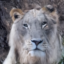

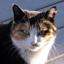

In [55]:
from IPython.display import Image, display

# Display the image
display(Image(filename="output_imgs/190.png"))
display(Image(filename="data/afhq/eval/flickr_cat_000056.jpg"))